# **Ziqi Zhang - 1001374684**  
# Assignment 2

##### Import Libraries and datasets

In [0]:
# import library
import numpy as np
import pandas as pd
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from html.parser import HTMLParser
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
# import datasets
election = pd.read_csv('/content/drive/My Drive/Master/MIE1624/A2/Canadian_elections_2019.csv')
sentiment = pd.read_csv('/content/drive/My Drive/Master/MIE1624/A2/Sentiment.csv').dropna()
sentiment = sentiment.loc[sentiment['sentiment'] != 'Neutral'].reset_index(drop=True)

# **1. Data Cleaning**

The tweets data given contains a lot of noise, which cannot be analyzed directly. Therefore, it needs to be cleaned first. The following procedures are applied:  
1. All html tags and attributes (i.e., /<[^>]+>/) are removed
2. Html character codes (i.e., &...;) are replaced with an ASCII equivalent
3. All URLs are removed
4. All characters in the text are in lowercase.
5. All stop words are removed.
6. Emoji is removed.
6. If a tweet is empty after pre-processing, it should be preserved as such.

In [0]:
class MLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ''.join(self.fed)

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

def notLetter(inputString):
  return any(char.isdigit() or (not char.isalpha()) for char in inputString)

def remove_stops(text, stopword):
  s1 = ' '
  text_str = []
  text = text['text'].split(' ')
  text = [value for value in text if not value in stopword]
  text_arr = [value for value in text if not notLetter(value)]
  #stem
  ps = PorterStemmer()
  text_arr = [ps.stem(word) for word in text_arr]
  text_str.append(s1.join(text_arr))
  return text_str, text_arr

def clean(data):
  # strip HTML tags
  data['text'] = data['text'].apply(lambda x: strip_tags(x))
  # remove URL and @
  data['text'] = data['text'].str.replace('http\S+|www.\S+|@\S+', '', case=False)
  # remove emoji tag
  data['text'] = data['text'].str.replace(r'\\\S\S\S','',case = False)
  # remove ,.!?
  data['text'] = data['text'].str.replace('\,|\.|\!|\?','',case = False)
  # replace HTML codes with ASCII equivalant
  data = data.replace({r'&#45':'-', r'&#39':'', r'&amp':'and', r'b"':'', r"b'":'', r'\\n':'', r'\n':'', r'#':''}, regex=True)
  # to lower case
  data['text'] = data['text'].str.lower()
  # create stop words list
  stopword = stopwords.words('english')
  add_stpwrd = ["","let's","it's","i'm","ur","they're","could"]
  for i in range(len(add_stpwrd)):
    stopword.append(add_stpwrd[i])
  # remove stop words and number
  data['key_words_str'] = data.apply(lambda x: remove_stops(x,stopword)[0][0], axis=1)
  # check for NaN, replace with space
  data.fillna('', inplace= True)

  return data

In [0]:
sentiment = clean(sentiment)
election = clean(election)

The following step replace 'Negative' and 'Positive' with 0 and 1. This step is not necessary if doing classification.

In [0]:
# replace 'Negative' and 'Positive' with 0 and 1
def convert(text):
  # print(text)
  if text=='Negative': 
    return 0
  if text=='Positive':
    return 1

sentiment['sentiment'] = sentiment['sentiment'].apply(lambda x: convert(x))
election['sentiment'] = election['sentiment'].apply(lambda x: convert(x))

# **2. Exploratory Analysis**

## 2.1 Determine Political Party

First, a procedure that decides the related party of a tweet. The general methodology is to look at some keywords related to each party. Detailed keywords are listed in the code below. The outcome of the algorithm can be 'Liberal', 'Conservarives', or 'ndp' is only one political party is mentioned. Or if multiple political parties are mentioned, all of the parties mentioned will appear. If no party is mentioned, 'none' is assigned.

In [0]:
'''
determine the party of each tweet
'''
# keywords
Liberal = ['liberal', 'justin', 'trudeau']
Conservative = ['conservative', 'andrew', 'scheer']
NDP = ['NDP', 'newdemocratic', 'jagmeet', 'singh']

def inlist(list1, list2):
  for item1 in list1:
    if any(item1 in item2 for item2 in list2):
      return True
  return False

def decideParty(text):
  length = 0
  presult = ''
  if inlist(Liberal,text['text'].split(' ')):
    presult = presult + 'liberal'
    length = length + 1
  if inlist(Conservative,text['text'].split(' ')):
    presult = presult + ' conservatives'
    length = length + 1
  if inlist(NDP,text['text'].split(' ')):
    presult = presult + ' ndp'
    length = length + 1
  if not presult:
    presult = presult + 'none'
  return presult, length

In [0]:
election['party'] = election.apply(lambda x: decideParty(x)[0], axis = 1)
election['#_party_mentioned'] = election.apply(lambda x: decideParty(x)[1],axis = 1)

The output of the algorithm with 2019 election dataset is shown below.

In [0]:
election

,sentiment,negative_reason,text,key_words_str,party,#_party_mentioned
0,0,Women Reproductive right and Racism,so instead of your suggestion how about we ag...,instead suggest agre canadian women trust andr...,conservatives,1
1,1,,allwomanspacewalk it's real tobicokenorth city...,allwomanspacewalk real tobicokenorth cityofto ...,none,0
2,0,Economy,brantford it's going to cost you $94 billion f...,brantford go cost billion next year ask justin...,liberal,1
3,1,,canada canadaelection2019 canadavotes lxn43 ca...,canada canadavot decid help,none,0
4,0,Economy,canada taxpayers are sick & tired of having th...,canada taxpay sick tire hard earn donat corpor...,liberal,1
...,...,...,...,...,...,...
2128,0,Scandal,you know he was doing a good enough job smeari...,know good enough job smear campaign right cdnp...,none,0
2129,0,Scandal,you missed the comment deflecting the issue do...,miss comment deflect issu answer best respons ...,none,0
2130,1,,your daily reminder: endorses strategic voting...,daili endors strateg cdnpoli lpc ndp gpc,none,0
2131,0,Women Reproductive right and Racism,yupnot going to reopen the abortion debatelxn4...,yupnot go reopen abort scheerli scheerhypocrisi,conservatives,1


## 2.2 Data Visualization

### 2.2.1 Generic Tweets

We first look at the number of negative tweets comparing to positive tweets.

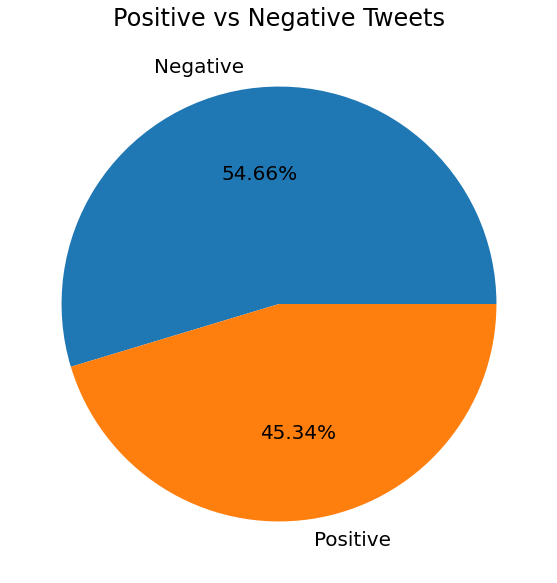

In [0]:
neg_twt_count = sentiment['sentiment'].value_counts()[0]
pos_twt_count = sentiment['sentiment'].value_counts()[1]

plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(10,10))
label = ['Negative', 'Positive']
tweet_number = [neg_twt_count, pos_twt_count]
plt.pie(tweet_number, labels = label,autopct='%1.2f%%')
plt.title('Positive vs Negative Tweets')
plt.show()

From the above pie chart, we can see that there are more complains are on tweeter than positive contents.  
Then, let's look at the most popular words in all the tweets.

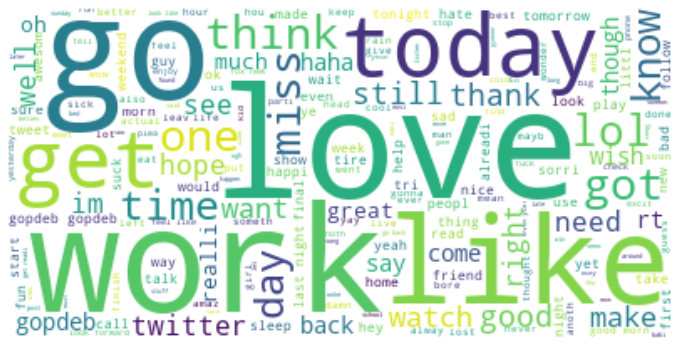

In [0]:
from wordcloud import WordCloud
stopword = stopwords.words('english')
plt.figure(figsize=(12, 10))
plt.axis("off")
words = pd.Series(sentiment['key_words_str'].tolist()).str.cat(sep=' ')
word_cloud = WordCloud(stopwords=stopword,background_color='white').generate(words)
plt.imshow(word_cloud, interpolation="bilinear")
plt.show()

It is interesting that although there are more negative tweets than positive tweets, the most commonly used words are positive, like 'love', 'hope', etc. Maybe people tend to complain about different things?

### 2.2.2 Election Related Tweets

First, let's see which party is mostly discussed.



In [0]:
party_count = election['party'].value_counts()

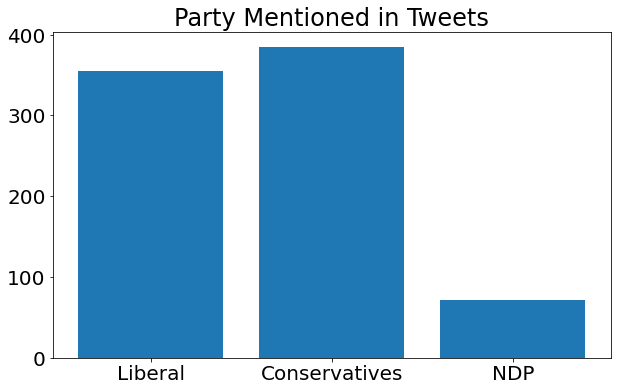

In [0]:
lib_count = party_count[2] + party_count[3]/2 + party_count[5]/2 + party_count[6]/3
cons_count = party_count[1] + party_count[3]/2 + party_count[7]/2 + party_count[6]/3
ndp_count = party_count[4] + party_count[5]/2 + party_count[7]/2 + party_count[6]/3
none_count = party_count[0]

plt.figure(figsize=(10,6))
label = ['Liberal', 'Conservatives', 'NDP']
tweet_number = [lib_count, cons_count, ndp_count]
plt.bar(label, tweet_number)
plt.title('Party Mentioned in Tweets')
plt.show()

Looks like the battle is between Liberal and Conservatives since NDP is much less mentioned by the public. Next, let's look into the most mentioned words in political tweets.


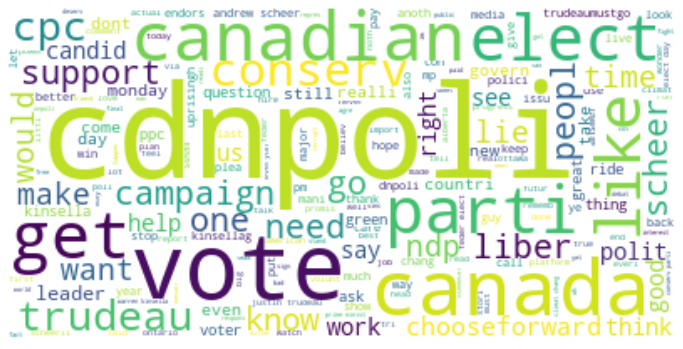

In [0]:
stopword = stopwords.words('english')
plt.figure(figsize=(12, 10))
plt.axis("off")
words = pd.Series(election['key_words_str'].tolist()).str.cat(sep=' ')
word_cloud = WordCloud(stopwords=stopword,background_color='white').generate(words)
plt.imshow(word_cloud, interpolation="bilinear")
plt.show()

The most common used word 'cdnpoli' is from the hastag '#cdnpoli'. By adding such hastag, the tweet can be seen by more others. The popularity of such a hastag means that majority of the people who tweet political content is willing to share his/her opinion with others.  
  
It is also catched attention that 'trudeau' and 'scheer' appear in the wordcloud. It indicates that people believes that the winner will be between Liberal and Conservatives, and people are concerning about the policies of these two parties.

# **3. Feature Engineering**


In this part, the filtered string of tweets are transformed with two methods:  
- Word Frequency (WF)
- Term Frequency–Inverse Document Frequency (TF-IDF)  
  
The total number of unique words are about 100,000, which contains a lot of 'junk words' that only appear few times. For example, 'aaaarrrrrgggghhhh' and 'asaslkdvnskjdfh'. Therefore, the maximum number of features are set to 10,000.


### 3.1 Word Frequency (WF)


In [0]:
# WF
vectorizer_WF = CountVectorizer(analyzer='word',max_features=10000)
array_WF_sentiment = vectorizer_WF.fit_transform(sentiment['key_words_str'])
array_WF_election = vectorizer_WF.transform(election['key_words_str'])

### 3.2 Term Frequency–Inverse Document Frequency (TF-IDF)

In [0]:
# TF-IDF
vectorizer_TFIDF = TfidfVectorizer(use_idf=True, smooth_idf=True, norm=None, analyzer='word',max_features=10000)
array_TFIDF_sentiment = vectorizer_TFIDF.fit_transform(sentiment['key_words_str'])
array_TFIDF_election = vectorizer_TFIDF.transform(election['key_words_str'])

# **4. Model Implementation**

In this section, 7 machine learning models are implemented to classify either a tweet is positive or negative. The features are set to the transformed WF and Tf-IDF martrix. The target is true 'sentiment' label from the original sentiment.csv dataset. Comparison between the two types of features are made. The implemented ML algorithms are:  
- Logistic Regression
- k-NN
- Naive Bayes
- SVM
- Decision Tree
- XG Boost
- Random Forest  
  
Training and testing data are 70:30 splited. Grid Search is used on Logistic Regression, k-NN, Naive Bayes, and SVm. Decision Tree based algorithms are not frid searched due to the time limitation.

##### Import Libraries


In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
np.random.seed(2222)

## 4.1 Train Models with WF as Features

### 4.1.1 Data Preperation

In [0]:
# split data into training and testing set
train = array_WF_sentiment
test = sentiment['sentiment']
X_train, X_test, y_train, y_test = model_selection.train_test_split(train, test, test_size=0.3)

### 4.1.2 Logistic Regression

In [0]:
from sklearn.linear_model import LogisticRegression

In [0]:
param_grid = {'penalty' : ['l1', 'l2'],
              'C':[0.1,0.5,1,5,10],
              'solver' : ['liblinear']}
lr_wf = LogisticRegression(max_iter = 1000)
gs_lr_wf = GridSearchCV(estimator = lr_wf, param_grid = param_grid, scoring = 'accuracy').fit(X_train, y_train)
print('---------done training, best params: ', gs_lr_wf.best_params_)
lr_wf_train_score = gs_lr_wf.score(X_train,y_train)
lr_wf_test_score = gs_lr_wf.score(X_test,y_test)
print('Training Accuracy:', lr_wf_train_score)
print('Testing Accuracy:', lr_wf_test_score)

---------done training, best params:  {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Training Accuracy: 0.7960156574602549
Testing Accuracy: 0.7576345128453709


### 4.1.3 k-NN

In [0]:
from sklearn.neighbors import KNeighborsClassifier

In [0]:
param_grid = {'n_neighbors' : [5, 10, 30]}
knn_wf = KNeighborsClassifier()
gs_knn_wf = GridSearchCV(estimator = knn_wf, param_grid = param_grid, scoring = 'accuracy').fit(X_train, y_train)
print('---------done training, best params: ', gs_knn.best_params_)
knn_wf_train_score = gs_knn_wf.score(X_train,y_train)
knn_wf_test_score = gs_knn_wf.score(X_test,y_test)
print('Training Accuracy:', knn_wf_train_score)
print('Testing Accuracy:', knn_wf_test_score)

---------done training, best params:  {'n_neighbors': 30}
Training Accuracy: 0.7442541931815697
Testing Accuracy: 0.6763017577875858


### 4.1.4 Naive Bayes

In [0]:
from sklearn.naive_bayes import MultinomialNB

In [0]:
param_grid = {'alpha' : [0.1,1,5,10,50,100]}
nbm_wf = MultinomialNB()
gs_nbm_wf = GridSearchCV(estimator = nbm_wf, param_grid = param_grid, scoring = 'accuracy').fit(X_train, y_train)
print('---------done training, best params: ', gs_nbm.best_params_)
nbm_wf_train_score = gs_nbm_wf.score(X_train,y_train)
nbm_wf_test_score = gs_nbm_wf.score(X_test,y_test)
print('Training Accuracy:', nbm_wf_train_score)
print('Testing Accuracy:', nbm_wf_test_score)

---------done training, best params:  {'alpha': 100}
Training Accuracy: 0.7709549738677863
Testing Accuracy: 0.7457713600530653


### 4.1.5 SVM

In [0]:
from sklearn.svm import LinearSVC
import warnings
warnings.filterwarnings("ignore")

In [0]:
param_grid = {'C':[0.1,1,5]}
svm_wf = LinearSVC(max_iter=5000)
gs_svm_wf = GridSearchCV(estimator = svm_wf, param_grid = param_grid, scoring = 'accuracy').fit(X_train, y_train)
print('---------done training, best params: ', gs_svm.best_params_)
svm_wf_train_score = gs_svm_wf.score(X_train,y_train)
svm_wf_test_score = gs_svm_wf.score(X_test,y_test)
print('Training Accuracy:', svm_wf_train_score)
print('Testing Accuracy:', svm_wf_test_score)

---------done training, best params:  {'C': 0.1}
Training Accuracy: 0.8010999584508737
Testing Accuracy: 0.7547261269995152


### 4.1.6 Decision Trees

In [0]:
from sklearn.tree import DecisionTreeClassifier

In [0]:
dt_wf = DecisionTreeClassifier(random_state=0, max_leaf_nodes = 50, max_depth=100).fit(X_train, y_train)
print('---------done training')
dt_wf_train_score = dt_wf.score(X_train,y_train)
dt_wf_test_score = dt_wf.score(X_test,y_test)
print('Training Accuracy:', dt_wf_train_score)
print('Testing Accuracy:', dt_wf_test_score)

---------done training
Training Accuracy: 0.6627085656804216
Testing Accuracy: 0.6627292905069265


### 4.1.7 XGBoost

In [0]:
import xgboost as xgb

In [0]:
xgbt_wf=xgb.XGBClassifier().fit(X_train, y_train)
print('---------done training')
xgbt_wf_train_score = xgbt_wf.score(X_train,y_train)
xgbt_wf_test_score = xgbt_wf.score(X_test,y_test)
print('Training Accuracy:', xgbt_wf_train_score)
print('Testing Accuracy:', xgbt_wf_test_score)

---------done training
Training Accuracy: 0.6682192919154147
Testing Accuracy: 0.6645661657779932


### 4.1.8 Random Forest

In [0]:
from sklearn.ensemble import RandomForestClassifier

In [0]:
rf_wf = RandomForestClassifier(max_depth=100).fit(X_train, y_train)
print('---------done training')
rf_wf_train_score = rf_wf.score(X_train,y_train)
rf_wf_test_score = rf_wf.score(X_test,y_test)
print('Training Accuracy:', rf_wf_train_score)
print('Testing Accuracy:', rf_wf_test_score)

---------done training
Training Accuracy: 0.8692514596864135
Testing Accuracy: 0.7454907263310968


## 4.2 Train Models with TF-IDF as Features

### 4.2.1 Data Preperation

In [0]:
# split data into training and testing set
train = array_TFIDF_sentiment
test = sentiment['sentiment']
X_train, X_test, y_train, y_test = model_selection.train_test_split(train, test, test_size=0.3)

### 4.2.2 Logistic Regression

In [0]:
from sklearn.linear_model import LogisticRegression

In [0]:
param_grid = {'penalty' : ['l1', 'l2'],
              'C':[0.1,0.5,1,5,10],
              'solver' : ['liblinear']}
lr_tfidf = LogisticRegression(max_iter = 1000)
gs_lr_tfidf = GridSearchCV(estimator = lr_tfidf, param_grid = param_grid, scoring = 'accuracy').fit(X_train, y_train)
print('---------done training, best params: ', gs_lr_tfidf.best_params_)
lr_tfidf_train_score = gs_lr_tfidf.score(X_train,y_train)
lr_tfidf_test_score = gs_lr_tfidf.score(X_test,y_test)
print('Training Accuracy:', lr_tfidf_train_score)
print('Testing Accuracy:', lr_tfidf_test_score)

---------done training, best params:  {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Training Accuracy: 0.7957532419252553
Testing Accuracy: 0.7594458759598949


### 4.2.3 k-NN

In [0]:
from sklearn.neighbors import KNeighborsClassifier

In [0]:
param_grid = {'n_neighbors' : [5, 10, 30]}
knn_tfidf = KNeighborsClassifier()
gs_knn_tfidf = GridSearchCV(estimator = knn_tfidf, param_grid = param_grid, scoring = 'accuracy').fit(X_train, y_train)
print('---------done training, best params: ', gs_knn.best_params_)
knn_tfidf_train_score = gs_knn_tfidf.score(X_train,y_train)
knn_tfidf_test_score = gs_knn_tfidf.score(X_test,y_test)
print('Training Accuracy:', knn_tfidf_train_score)
print('Testing Accuracy:', knn_tfidf_test_score)

---------done training, best params:  {'n_neighbors': 30}
Training Accuracy: 0.7237748474709703
Testing Accuracy: 0.6955379238207006


### 4.2.4 Naive Bayes

In [0]:
from sklearn.naive_bayes import MultinomialNB

In [0]:
param_grid = {'alpha' : [0.1,1,5,10,50,100]}
nbm_tfidf = MultinomialNB()
gs_nbm_tfidf = GridSearchCV(estimator = nbm_tfidf, param_grid = param_grid, scoring = 'accuracy').fit(X_train, y_train)
print('---------done training, best params: ', gs_nbm.best_params_)
nbm_tfidf_train_score = gs_nbm_tfidf.score(X_train,y_train)
nbm_tfidf_test_score = gs_nbm_tfidf.score(X_test,y_test)
print('Training Accuracy:', nbm_tfidf_train_score)
print('Testing Accuracy:', nbm_tfidf_test_score)

---------done training, best params:  {'alpha': 100}
Training Accuracy: 0.7705176146427869
Testing Accuracy: 0.7460775059315764


### 4.2.5 SVM

In [0]:
from sklearn.svm import LinearSVC
import warnings
warnings.filterwarnings("ignore")

In [0]:
param_grid = {'C':[0.1,1,5]}
svm_tfidf = LinearSVC(max_iter=5000)
gs_svm_tfidf = GridSearchCV(estimator = svm_tfidf, param_grid = param_grid, scoring = 'accuracy').fit(X_train, y_train)
print('---------done training, best params: ', gs_svm.best_params_)
svm_tfidf_train_score = gs_svm_tfidf.score(X_train,y_train)
svm_tfidf_test_score = gs_svm_tfidf.score(X_test,y_test)
print('Training Accuracy:', svm_tfidf_train_score)
print('Testing Accuracy:', svm_tfidf_test_score)

---------done training, best params:  {'C': 0.1}
Training Accuracy: 0.8093879157646132
Testing Accuracy: 0.741970048728219


### 4.2.6 Decision Tree

In [0]:
from sklearn.tree import DecisionTreeClassifier

In [0]:
dt_tfidf = DecisionTreeClassifier(random_state=0, max_leaf_nodes = 50, max_depth=100).fit(X_train, y_train)
print('---------done training')
dt_tfidf_train_score = dt_tfidf.score(X_train,y_train)
dt_tfidf_test_score = dt_tfidf.score(X_test,y_test)
print('Training Accuracy:', dt_tfidf_train_score)
print('Testing Accuracy:', dt_tfidf_test_score)

---------done training
Training Accuracy: 0.6637691618010453
Testing Accuracy: 0.6619384136541062


### 4.2.7 XG Boost

In [0]:
import xgboost as xgb

In [0]:
xgbt_tfidf=xgb.XGBClassifier().fit(X_train, y_train)
print('---------done training')
xgbt_tfidf_train_score = xgbt_tfidf.score(X_train,y_train)
xgbt_tfidf_test_score = xgbt_tfidf.score(X_test,y_test)
print('Training Accuracy:', xgbt_tfidf_train_score)
print('Testing Accuracy:', xgbt_tfidf_test_score)

ERROR! Session/line number was not unique in database. History logging moved to new session 60
---------done training
Training Accuracy: 0.6658356841391677
Testing Accuracy: 0.6675766002500191


### 4.2.8 Random Forest

In [0]:
from sklearn.ensemble import RandomForestClassifier

In [0]:
rf_tfidf = RandomForestClassifier(max_depth=100).fit(X_train, y_train)
print('---------done training')
rf_tfidf_train_score = rf_tfidf.score(X_train,y_train)
rf_tfidf_test_score = rf_tfidf.score(X_test,y_test)
print('Training Accuracy:', rf_tfidf_train_score)
print('Testing Accuracy:', rf_tfidf_test_score)

---------done training
Training Accuracy: 0.8701152441557873
Testing Accuracy: 0.7444447279128504


## 4.3 Best Model

In [0]:
# choose best model
sentiment_test_result_wf = [lr_wf_test_score,knn_wf_test_score,nbm_wf_test_score,svm_wf_test_score,dt_wf_test_score,xgbt_wf_test_score,rf_wf_test_score] 
sentiment_test_result_tfidf = [lr_tfidf_test_score,knn_tfidf_test_score,nbm_tfidf_test_score,svm_tfidf_test_score,dt_tfidf_test_score,xgbt_tfidf_test_score,rf_tfidf_test_score]
models = ['LR','KNN','NB','SVM','DT','XGBT','RF']
features = ['WF', 'TFIDF']

print('Model Accuracy')
sentiment_result = pd.DataFrame(list(zip(sentiment_test_result_wf,sentiment_test_result_tfidf)), index = models, columns = features)
sentiment_result['avg'] = sentiment_result.mean(axis = 1)
sentiment_result['rank'] = sentiment_result['avg'].rank(ascending=False)
sentiment_result = sentiment_result.sort_values(by ='rank' )
sentiment_result

Model Accuracy


,WF,TFIDF,avg,rank
LR,0.757635,0.759446,0.758540,1.0
SVM,0.754726,0.741970,0.748348,2.0
NB,0.745771,0.746078,0.745924,3.0
RF,0.745491,0.744445,0.744968,4.0
KNN,0.676302,0.695538,0.685920,5.0
XGBT,0.664566,0.667577,0.666071,6.0
DT,0.662729,0.661938,0.662334,7.0


By taking the average of the testing accuracy of WF and TF-IDF dataset, we can see that Logistic Regression, SVM, Naive Bayes, and Random Forest performs well with above 70% accuracy. k-NN, XG Boost, and Decision Tree does not reach 70% accuracy.

## 4.4 Model Performance on 2019 Election Data

In this section, we look at how the models trained based on generic tweets perform on political data. Like generic tweets, both WF and TF-IDF transformation are done to political tweets.

### 4.4.1 Data Preperation

In [0]:
# reset target
y_elec = election['sentiment']

### 4.4.2 Prediction Results

In [0]:
# lr
print('Logistic Regression:')
elec_lr_wf_score = gs_lr_wf.score(array_WF_election,y_elec)
elec_lr_tfidf_score = gs_lr_tfidf.score(array_TFIDF_election,y_elec)
print('WF: {0}, TF-IDF: {1}\n'.format(elec_lr_wf_score,elec_lr_tfidf_score))
# knn
print('k-NN:')
elec_knn_wf_score = gs_knn_wf.score(array_WF_election,y_elec)
elec_knn_tfidf_score = gs_knn_tfidf.score(array_TFIDF_election,y_elec)
print('WF: {0}, TF-IDF: {1}\n'.format(elec_knn_wf_score,elec_knn_tfidf_score))
# nb
print('Naive Bayes:')
elec_nb_wf_score = gs_nbm_wf.score(array_WF_election,y_elec)
elec_nb_tfidf_score = gs_nbm_tfidf.score(array_TFIDF_election,y_elec)
print('WF: {0}, TF-IDF: {1}\n'.format(elec_nb_wf_score,elec_nb_tfidf_score))
# SVM
print('SVM:')
elec_svm_wf_score = gs_svm_wf.score(array_WF_election,y_elec)
elec_svm_tfidf_score = gs_svm_tfidf.score(array_TFIDF_election,y_elec)
print('WF: {0}, TF-IDF: {1}\n'.format(elec_svm_wf_score,elec_svm_tfidf_score))
# dt
print('Decision Tree:')
elec_dt_wf_score = dt_wf.score(array_WF_election,y_elec)
elec_dt_tfidf_score = dt_tfidf.score(array_TFIDF_election,y_elec)
print('WF: {0}, TF-IDF: {1}\n'.format(elec_dt_wf_score,elec_dt_tfidf_score))
# xgbt
print('XG Boost:')
elec_xgbt_wf_score = xgbt_wf.score(array_WF_election,y_elec)
elec_xgbt_tfidf_score = xgbt_tfidf.score(array_TFIDF_election,y_elec)
print('WF: {0}, TF-IDF: {1}\n'.format(elec_xgbt_wf_score,elec_xgbt_tfidf_score))
# rf
print('Random Forest:')
elec_rf_wf_score = rf_wf.score(array_WF_election,y_elec)
elec_rf_tfidf_score = rf_tfidf.score(array_TFIDF_election,y_elec)
print('WF: {0}, TF-IDF: {1}\n'.format(elec_rf_wf_score,elec_rf_tfidf_score))

Logistic Regression:
WF: 0.6235349273323957, TF-IDF: 0.6272855133614628

k-NN:
WF: 0.5260196905766527, TF-IDF: 0.5527426160337553

Naive Bayes:
WF: 0.593061415846226, TF-IDF: 0.5972808251289264

SVM:
WF: 0.616502578527895, TF-IDF: 0.6183778715424285

Decision Tree:
WF: 0.5278949835911861, TF-IDF: 0.5274261603375527

XG Boost:
WF: 0.5185185185185185, TF-IDF: 0.5199249882794187

Random Forest:
WF: 0.5911861228316925, TF-IDF: 0.5799343647444913



From the above accuracy results, we can see that the performance ranking for the models remain the same, with LR and SVM being the optimal choice. However, the overall accuracy dropped from around 70% to 60%. It is caused by the difference in word usage in generic tweets and political tweets.

## 4.5 Prediction for Each Party

In this section, we classify tweets that mentioned each party are either positive and negative. And hopefully, we can get some insight for the election from the result. Logistic Regression is used since it performs best in the previous sections.

### 4.5.1 Liberal

In [0]:
# filter tweets for liberal
election_liberal = election[election['party']=='liberal']
# prepare training and testing data
array_liberal = vectorizer_TFIDF.transform(election_liberal['key_words_str'])
y = election_liberal['sentiment']
# lr
lib_pred = gs_lr_tfidf.predict(array_liberal)
print('accuracy: ', accuracy_score(y, lib_pred))

accuracy:  0.6076388888888888


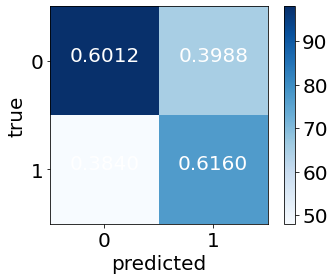

In [0]:
from sklearn.metrics import confusion_matrix
# plot confusion matrix
np.set_printoptions(precision=4)
cm = confusion_matrix(election_liberal['sentiment'], lib_pred)
#set parameters for plotting confusion matrix
def plot_confusion_matrix(cm, classes, normalize=True, title=None, cmap=plt.cm.Blues):

  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  # plot elements
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  # plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  plt.ylim([1.5, -0.5])
  plt.xlabel('predicted')
  plt.ylabel('true')
  # normalize
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  #text elements
  thresh = cm.max() / 2.
  for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
      plt.text(j, i, format(cm[i, j], '.4f'),
                ha="center",
                color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plot_confusion_matrix(cm, classes=['0','1'])

### 4.5.2 Conservatives

In [0]:
# filter tweets for conservatives
election_conservatives = election[election['party']==' conservatives']
# prepare training and testing data
array_conservatives = vectorizer_TFIDF.transform(election_conservatives['key_words_str'])
y = election_conservatives['sentiment']
# lr
cons_pred = gs_lr_tfidf.predict(array_conservatives)
print('accuracy: ', accuracy_score(y, cons_pred))

accuracy:  0.6261682242990654


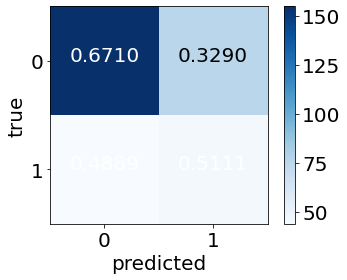

In [0]:
from sklearn.metrics import confusion_matrix
# plot confusion matrix
np.set_printoptions(precision=4)
cm = confusion_matrix(election_conservatives['sentiment'], cons_pred)
#set parameters for plotting confusion matrix
def plot_confusion_matrix(cm, classes, normalize=True, title=None, cmap=plt.cm.Blues):

  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  # plot elements
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  # plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  plt.ylim([1.5, -0.5])
  plt.xlabel('predicted')
  plt.ylabel('true')
  # normalize
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  #text elements
  thresh = cm.max() / 2.
  for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
      plt.text(j, i, format(cm[i, j], '.4f'),
                ha="center",
                color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plot_confusion_matrix(cm, classes=['0','1'])

### 4.5.3 NDP

In [0]:
# filter tweets for ndp
election_ndp = election[election['party']==' ndp']
# prepare training and testing data
array_ndp = vectorizer_TFIDF.transform(election_ndp['key_words_str'])
y = election_ndp['sentiment']
# lr
ndp_pred = gs_lr_tfidf.predict(array_ndp)
print('accuracy: ', accuracy_score(y, ndp_pred))

accuracy:  0.5517241379310345


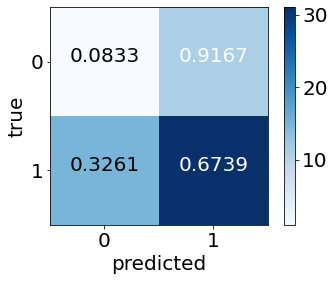

In [0]:
from sklearn.metrics import confusion_matrix
# plot confusion matrix
np.set_printoptions(precision=4)
cm = confusion_matrix(election_ndp['sentiment'], ndp_pred)
#set parameters for plotting confusion matrix
def plot_confusion_matrix(cm, classes, normalize=True, title=None, cmap=plt.cm.Blues):

  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  # plot elements
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  # plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  plt.ylim([1.5, -0.5])
  plt.xlabel('predicted')
  plt.ylabel('true')
  # normalize
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  #text elements
  thresh = cm.max() / 2.
  for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
      plt.text(j, i, format(cm[i, j], '.4f'),
                ha="center",
                color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plot_confusion_matrix(cm, classes=['0','1'])

### 4.5.4 Conclusion

From the above confusion matrix, we can see that the ML algorithm performs better with Liberal and Conservatives than NDP. This might be caused by the smaller sample size that NDP has.

## 4.6 Classify Reasons for Negative Tweets

In this section, classification is made on negative tweets from election topics only. The target is defined as the reasons of such a tweet is negative. 10 reasons are given in total. 

In [0]:
# filter out non-negative tweets
neg_twt = election[election['sentiment']==0]

In [0]:
# TF-IDF
vectorizer_TFIDF_neg = TfidfVectorizer(use_idf=True, smooth_idf=True, norm=None, analyzer='word',max_features=10000)
array_TFIDF_neg = vectorizer_TFIDF_neg.fit_transform(neg_twt['key_words_str'])

In [0]:
# split data into training and testing set
train = array_TFIDF_neg
test = neg_twt['negative_reason']
X_train, X_test, y_train, y_test = model_selection.train_test_split(train, test, test_size=0.3)

In [0]:
# lr
param_grid = {'penalty' : ['l1', 'l2'],
              'C':[0.1,0.5,1,5,10],
              'solver' : ['lbfgs']}
lr_tfidf_neg = LogisticRegression(max_iter = 100)
gs_lr_tfidf_neg = GridSearchCV(estimator = lr_tfidf_neg, cv = 5, param_grid = param_grid, scoring = 'accuracy').fit(X_train, y_train)
print('---------done training, best params: ', gs_lr_tfidf_neg.best_params_)
lr_tfidf_train_score_neg = gs_lr_tfidf_neg.score(X_train,y_train)
lr_tfidf_test_score_neg = gs_lr_tfidf_neg.score(X_test,y_test)
print('Training Accuracy:', lr_tfidf_train_score_neg)
print('Testing Accuracy:', lr_tfidf_test_score_neg)
neg_lr_pred = gs_lr_tfidf_neg.predict(X_test)

---------done training, best params:  {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Training Accuracy: 0.9985795454545454
Testing Accuracy: 0.5827814569536424


In [0]:
# svm
param_grid = {'C':[0.1,1,5]}
svm_tfidf_neg = LinearSVC(max_iter=100)
gs_svm_tfidf_neg = GridSearchCV(estimator = svm_tfidf_neg, param_grid = param_grid, scoring = 'accuracy').fit(X_train, y_train)
print('---------done training, best params: ', gs_svm_tfidf_neg.best_params_)
svm_tfidf_train_score_neg = gs_svm_tfidf_neg.score(X_train,y_train)
svm_tfidf_test_score_neg = gs_svm_tfidf_neg.score(X_test,y_test)
print('Training Accuracy:', svm_tfidf_train_score_neg)
print('Testing Accuracy:', svm_tfidf_test_score_neg)

---------done training, best params:  {'C': 0.1}
Training Accuracy: 0.9985795454545454
Testing Accuracy: 0.5298013245033113


In [0]:
# XG Boost
xgbt_tfidf_neg=xgb.XGBClassifier().fit(X_train, y_train)
print('---------done training')
xgbt_tfidf_train_score_neg = xgbt_tfidf_neg.score(X_train,y_train)
xgbt_tfidf_test_score_neg = xgbt_tfidf_neg.score(X_test,y_test)
print('Training Accuracy:', xgbt_tfidf_train_score_neg)
print('Testing Accuracy:', xgbt_tfidf_test_score_neg)

---------done training
Training Accuracy: 0.7514204545454546
Testing Accuracy: 0.5794701986754967


Confusion Matrix

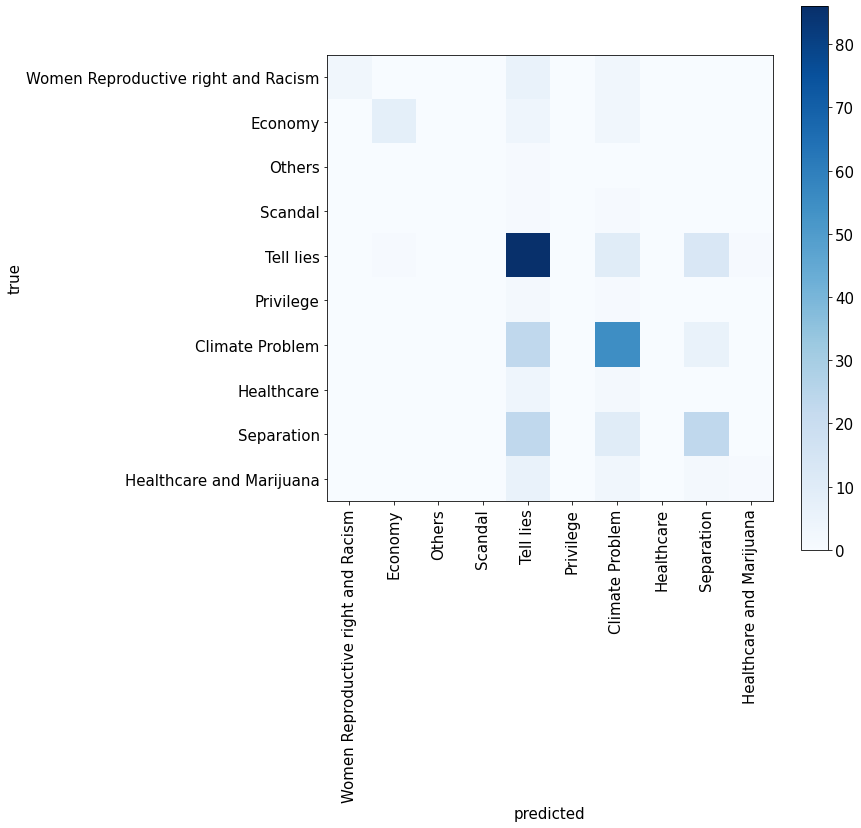

In [0]:
from matplotlib.pyplot import figure
# plot confusion matrix
np.set_printoptions(precision=4)
cm = confusion_matrix(y_test, neg_lr_pred)
#set parameters for plotting confusion matrix
def plot_confusion_matrix(cm, classes, normalize=True, title=None, cmap=plt.cm.Blues):

  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  # plot elements
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=90)
  plt.yticks(tick_marks, classes)

  plt.rcParams.update({'font.size': 15})
  plt.rcParams.update({'figure.figsize': [9,9]})
  plt.ylim([9.5, -0.5])
  plt.xlabel('predicted')
  plt.ylabel('true')
  # normalize
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  # #text elements
  # thresh = cm.max() / 2.
  # for i in range(cm.shape[0]):
  #   for j in range(cm.shape[1]):
  #     plt.text(j, i, format(cm[i, j], '.4f'),
  #               ha="center",
  #               color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
classes = ['Women Reproductive right and Racism', 'Economy', 'Others','Scandal', 'Tell lies', 'Privilege', 'Climate Problem','Healthcare', 'Separation', 'Healthcare and Marijuana']
plot_confusion_matrix(cm, classes=classes)

We can observe overfitting occurs in all three models. This might be caused by the small sample size and imbalance in the dataset. To solve such issue, more observations are required.

# **5. Results**

From the 2019 election related tweets, we can see that for both Liberal and Conservative, there are more negative tweets than positive tweets. It means that people have concerns for both parties. NDP is not as much discussed as the other two parties. Therefore, from the data point of view, the winner of the 2019 election will be between Liberal and Conservatives. Also, Liberal has more chagne of winning, since its positive/negative ratio is higher than Conservatives. Or at least, winning among people who use twitter.

The second algorithm might fail to predict the right reasoning for the negative tweets since different people can talk about the same thing with different wording. For example, for scandal, it could be related to a certain person from a party, or the corruption of the system of the party. 10 negative reasons are too much for such a small dataset. To improve the performance of the algorithm, more data is required.
